In [1]:
import numpy as np              # linear algebra
import pandas as pd             # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns           # statistical data visualization
%matplotlib inline
import os
import pyarrow
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:

df       = pd.read_feather("final_matrices/data.feather")
features = df.T.astype('uint16')


In [9]:

gene_names = pd.read_feather("final_matrices/gene_names.feather")


In [10]:

features.columns = gene_names['rownames(a)'].tolist()


In [11]:

metadata = pd.read_csv("final_matrices/all_metadata.csv")
metadata.columns = ['barcode', 'label']
metadata[metadata['label'] == "Astrocyte"] = "Astro"
metadata[metadata['label'] == "Microglia"] = "Micro"


In [12]:

all_indices = np.arange(df.shape[1])

train_fraction      = 0.7
validation_fraction = 0.15


In [86]:

random.shuffle(all_indices)

train_indices = all_indices[0:int(train_fraction*len(all_indices))].tolist()
val_indices   = all_indices[int(train_fraction*len(all_indices)):int((train_fraction+validation_fraction)*len(all_indices))].tolist()
test_indices  = all_indices[int((train_fraction+validation_fraction)*len(all_indices)):].tolist()


In [87]:

train_set = features.iloc[train_indices, :]
val_set   = features.iloc[val_indices,   :]
test_set  = features.iloc[test_indices,  :]


In [88]:

train_set_label  = metadata.loc[train_indices, :]['label'].values
val_set_label    = metadata.loc[val_indices,   :]['label'].values
test_set_label   = metadata.loc[test_indices,  :]['label'].values


In [89]:
set(val_set_label)

{'Astro', 'Excite', 'Inhibit', 'Micro', 'OPC', 'Oligo'}

In [90]:
set(test_set_label)

{'Astro', 'Excite', 'Inhibit', 'Micro', 'OPC', 'Oligo'}

In [92]:
def chunks(X, y, chunk_size):
    """
    Generator to yield chunks of data.
    
    Parameters:
    - X: The feature matrix.
    - y: The label array.
    - chunk_size: The size of each chunk.
    
    Yields:
    - A dictionary with keys 'X' (features) and 'y' (labels) for each chunk.
    """
    for start in range(0, len(X), chunk_size):
        end = start + chunk_size
        yield {'X': X[start:end], 'y': y[start:end]}


In [93]:

clf = RandomForestClassifier(n_estimators=25, warm_start=True, random_state=42)


In [94]:

for chunk in chunks(train_set, train_set_label, chunk_size=25000):  # Define your chunking logic
    #print(chunk)
    clf.n_estimators += 25
    clf.fit(chunk['X'], chunk['y'])
    
    

In [97]:

y_pred_train = clf.predict(train_set)
y_pred_val   = clf.predict(val_set)
y_pred_test  = clf.predict(test_set)


In [98]:

print("Training Accuracy:"  , accuracy_score(train_set_label, y_pred_train))
print("Validation Accuracy:", accuracy_score(val_set_label  , y_pred_val))
print("Test Accuracy:"      , accuracy_score(test_set_label , y_pred_test))


Training Accuracy: 0.9671434999437549
Validation Accuracy: 0.966724022281198
Test Accuracy: 0.9654116480503951


In [101]:

print("Classification Report:")
print(classification_report(train_set_label, y_pred_train))


Classification Report:
              precision    recall  f1-score   support

       Astro       1.00      0.97      0.98     20921
      Excite       0.97      0.98      0.98    171109
     Inhibit       0.97      0.97      0.97     69463
       Micro       0.92      0.93      0.92      7290
         OPC       0.94      0.75      0.83     11804
       Oligo       0.96      0.97      0.97     39441

    accuracy                           0.97    320028
   macro avg       0.96      0.93      0.94    320028
weighted avg       0.97      0.97      0.97    320028



In [102]:

print("Classification Report:")
print(classification_report(val_set_label, y_pred_val))


Classification Report:
              precision    recall  f1-score   support

       Astro       1.00      0.97      0.98      4359
      Excite       0.97      0.98      0.97     36845
     Inhibit       0.97      0.97      0.97     14734
       Micro       0.92      0.93      0.92      1608
         OPC       0.94      0.75      0.83      2573
       Oligo       0.96      0.97      0.97      8459

    accuracy                           0.97     68578
   macro avg       0.96      0.93      0.94     68578
weighted avg       0.97      0.97      0.97     68578



In [103]:

print("Classification Report:")
print(classification_report(test_set_label, y_pred_test))


Classification Report:
              precision    recall  f1-score   support

       Astro       1.00      0.97      0.98      4435
      Excite       0.97      0.98      0.97     36814
     Inhibit       0.97      0.97      0.97     14834
       Micro       0.92      0.93      0.93      1689
         OPC       0.93      0.73      0.82      2523
       Oligo       0.96      0.97      0.96      8283

    accuracy                           0.97     68578
   macro avg       0.96      0.92      0.94     68578
weighted avg       0.97      0.97      0.96     68578



In [106]:
top_features

array([ 3900,  6839,  3901, 10159,  3306,  9564, 12033, 10206,   728,
        8143])

In [111]:
[gene_names['rownames(a)'].tolist()[i] for i in top_features]

['GAD1',
 'NRGN',
 'GAD2',
 'SV2B',
 'ERBB4',
 'SLC6A1',
 'ZNF536',
 'SYT1',
 'ARPP21',
 'PTPRD']

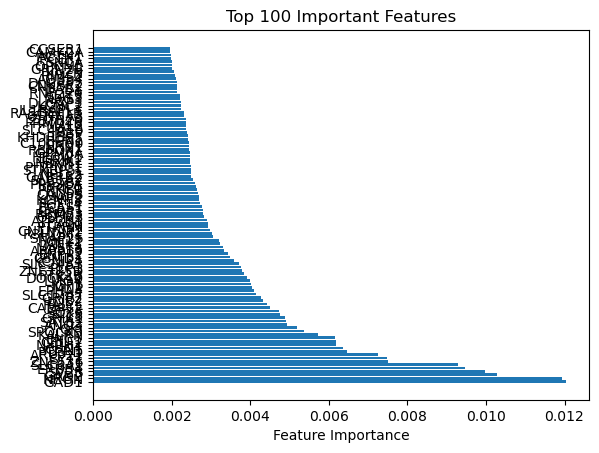

In [117]:

import matplotlib.pyplot as plt
import numpy as np

feature_importances = clf.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]
top_features = sorted_idx[:100]  # Top 10 features

plt.barh(range(len(top_features)), feature_importances[top_features])
plt.yticks(range(len(top_features)), [gene_names['rownames(a)'].tolist()[i] for i in top_features])
plt.xlabel("Feature Importance")
plt.title("Top 100 Important Features")
plt.show()


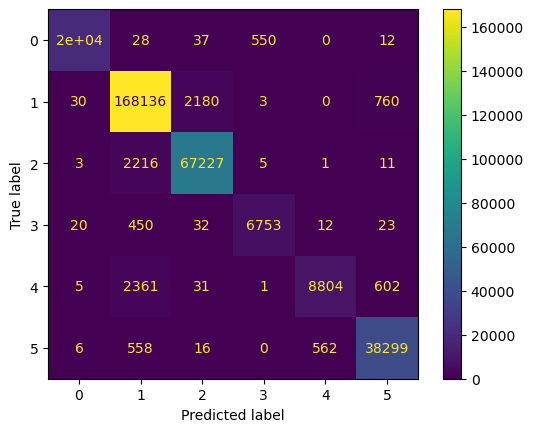

In [114]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(train_set_label, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()



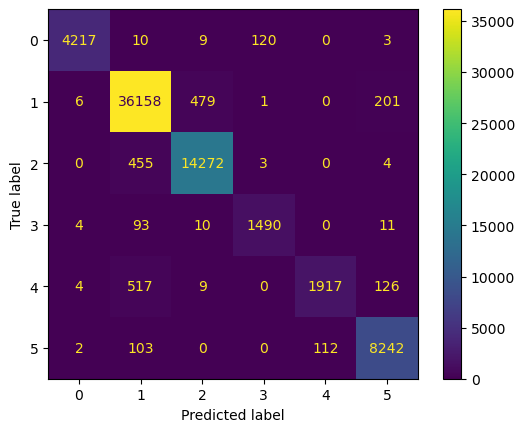

In [116]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(val_set_label, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()



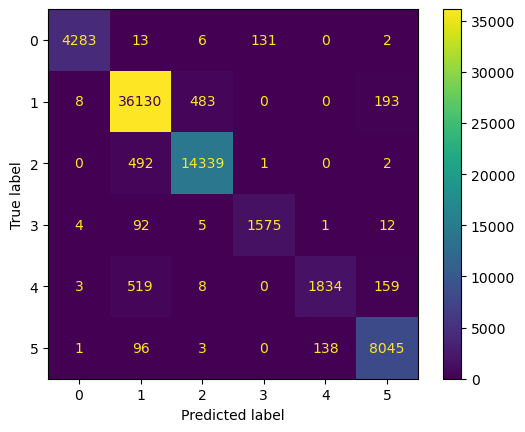

In [113]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_set_label, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
